In [1]:
import sys
sys.path.append('../')
from util.my_plot import layer,plot_images_labels_prediction, plot_batch

Using TensorFlow backend.


In [2]:
from __future__ import print_function

import numpy as np
import tensorflow as tf
import time

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)



Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# Build a convolutional neural network
def conv_net(x, reuse):
    with tf.variable_scope('ConvNet', reuse=reuse):
        
        x = tf.reshape(x, shape=[-1, 28, 28, 1])
        
        # Convolution Layer with 16 filters and a kernel size of 5
        x = tf.layers.conv2d(x, 16, 5, activation=tf.nn.relu)
        
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        x = tf.layers.max_pooling2d(x, 2, 2)
        
        # Convolution Layer with 36 filters and a kernel size of 5
        x = tf.layers.conv2d(x, 36, 5, activation=tf.nn.relu)
        
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        x = tf.layers.max_pooling2d(x, 2, 2)


        # Flatten the data to a 1-D vector for the fully connected layer
        x = tf.contrib.layers.flatten(x)

        # Fully connected layer (in contrib folder for now)
        x = tf.layers.dense(x, 256)
        
        # Apply Dropout (if is_training is False, dropout is not applied)
        x = tf.layers.dropout(x, rate=0.5)

        # Output layer, class prediction
        x = tf.layers.dense(x, 10)
        

        out = tf.nn.softmax(x)
    return out

In [4]:
# Build the function to average the gradients
def average_gradients(tower_grads):
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        # Note that each grad_and_vars looks like the following:
        #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, v in grad_and_vars:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)

            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(grads, 0)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads

In [5]:
# By default, all variables will be placed on '/gpu:0'
# So we need a custom device function, to assign all variables to '/cpu:0'
# Note: If GPUs are peered, '/gpu:0' can be a faster option
PS_OPS = ['Variable', 'VariableV2', 'AutoReloadVariable']

def assign_to_device(device, ps_device='/gpu:0'):
    def _assign(op):
        node_def = op if isinstance(op, tf.NodeDef) else op.node_def
        if node_def.op in PS_OPS:
            return "/" + ps_device
        else:
            return device

    return _assign

In [6]:
# Place all ops on CPU by default
num_gpus = 2
batchSize = 100

with tf.device('/gpu:0'):
    tower_grads = []
    reuse_vars = False

    # tf Graph input
    X = tf.placeholder(tf.float32, [None, 784])
    Y = tf.placeholder(tf.float32, [None, 10])

    # Loop over all GPUs and construct their own computation graph
    for i in range(num_gpus):
        with tf.device(assign_to_device('/gpu:{}'.format(i), ps_device='/gpu:0')):
            
            # Split into seperate GPU
            _X = X[i * batchSize: (i+1) * batchSize]
            _Y = Y[i * batchSize: (i+1) * batchSize]


            # Create a graph for training
            logits_train = conv_net(_X, reuse=reuse_vars)


            # Define loss and optimizer (with train logits, for dropout to take effect)
            loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_train, labels=_Y))
            optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
            grads = optimizer.compute_gradients(loss_op)

            correct_pred = tf.equal(tf.argmax(logits_train, 1), tf.argmax(_Y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

            reuse_vars = True
            tower_grads.append(grads)

    tower_grads = average_gradients(tower_grads)
    train_op = optimizer.apply_gradients(tower_grads)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [7]:
trainEpochs = 15

totalBatchs = int(mnist.train.num_examples/batchSize)
epoch_list=[]
val_loss_list=[]
val_accuracy_list=[]
loss_list=[]
accuracy_list=[]


from time import time
startTime=time()



In [8]:
print(totalBatchs)

550


In [9]:
# Initializing the variables

init = tf.global_variables_initializer()
sess=tf.Session()   
sess.run(init)



for epoch in range(trainEpochs):
    
    ts = time()
    for i in range(totalBatchs):
        batch_x, batch_y = mnist.train.next_batch(batchSize * num_gpus)
        sess.run(train_op, feed_dict={X: batch_x/255, Y: batch_y})
    te = time() - ts

    # 計算training data的準確度 
    loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x[:5000]/255,
                                                         Y: batch_y[:5000]})
    print("Step " + str(epoch+1) + ": Minibatch Loss= " + \
          "{:.4f}".format(loss) + ", Training Accuracy= " + \
          "{:.3f}".format(acc) + ", %i Examples/sec" % int(batchSize*totalBatchs/te))
    
    # 計算validate data的準確度 
    

duration =time()-startTime
print("Train Finished takes:",duration)  

Step 1: Minibatch Loss= 1.6431, Training Accuracy= 0.820, 8196 Examples/sec
Step 2: Minibatch Loss= 1.5203, Training Accuracy= 0.940, 12086 Examples/sec
Step 3: Minibatch Loss= 1.5124, Training Accuracy= 0.960, 11996 Examples/sec
Step 4: Minibatch Loss= 1.5027, Training Accuracy= 0.970, 10039 Examples/sec
Step 5: Minibatch Loss= 1.5085, Training Accuracy= 0.960, 11261 Examples/sec
Step 6: Minibatch Loss= 1.4725, Training Accuracy= 1.000, 11993 Examples/sec
Step 7: Minibatch Loss= 1.4821, Training Accuracy= 0.980, 11321 Examples/sec
Step 8: Minibatch Loss= 1.4993, Training Accuracy= 0.960, 11492 Examples/sec
Step 9: Minibatch Loss= 1.4889, Training Accuracy= 0.980, 12068 Examples/sec
Step 10: Minibatch Loss= 1.4616, Training Accuracy= 1.000, 11594 Examples/sec
Step 11: Minibatch Loss= 1.4919, Training Accuracy= 0.970, 11877 Examples/sec
Step 12: Minibatch Loss= 1.4675, Training Accuracy= 0.990, 11558 Examples/sec
Step 13: Minibatch Loss= 1.4627, Training Accuracy= 1.000, 9490 Examples/s

# 評估模型準確率

In [10]:
print("Accuracy:", sess.run(accuracy,
                           feed_dict={X: mnist.test.images,
                                      Y: mnist.test.labels}))

Accuracy: 0.97


# 進行預測


In [16]:
prediction_result=sess.run(tf.argmax(logits_train,1),
                           feed_dict={X: mnist.test.images/255})

In [17]:
prediction_result[:10]

array([6, 0, 5, 4, 9, 9, 2, 1, 9, 4])

In [18]:
aa = mnist.test.images.reshape(10000,28,28)


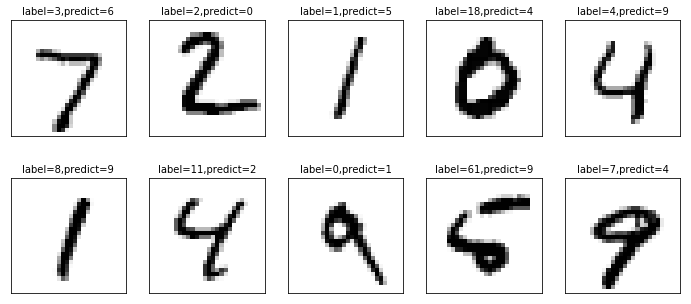

In [20]:
plot_images_labels_prediction(aa,
                              np.argmax(mnist.test.labels,axis=0),
                              prediction_result,0)

In [15]:
# sess.close()